# Believer / Denier Classification

My first classifier will attempt to separate my climate change tweets into believer tweets and denier tweets. I will be closely following the lead of [this article](https://towardsdatascience.com/classifying-climate-change-tweets-8245450a5e96) and using climate tweet IDs from the [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/5QCCUU) to gather tweets with which to train my classifier.

In [18]:
from datetime import datetime
import re
import string
import emoji
import spacy
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from datascience import *
import cld3
import numpy as np
%matplotlib inline

### Step 2: Identify tweets with definitive hashtags and annotate

To train the classifier, the article defines a set of hashtags that mark a tweet as believer or denier. The sets are below.

In [3]:
believer_hashtags = ["#climatechangeisreal", 
                     "#actonclimate", 
                     "#extinctionrebellion",
                     "#climateemergency",
                     "#climateactionnow"]

denier_hashtags = ["#climatechangeisfalse",
                   "#climatechangenotreal",
                   "#climatechangehoax",
                   "#globalwarminghoax",
                   "#tcot",
                   "#ccot",
                   "#tlot",
                   "#pjnet",
                   "#rednationrising",
                   "#votered",
                   "#libtard",
                   "#libtards"]

I need to get the list of tweets that contain these hashtags and mark them as believer or denier accordingly. I save these tweets in a separate file to access later.

In [3]:
tweets_file = open('harvard_climate_tweets.txt', 'r')
tweets = tweets_file.readlines()
tweets_file.close()

definitive_tweets = open('definitive_tweets.txt', 'w')

num_believer = 0
num_denier = 0

for tweet in tweets:
    tweet_is_believer = False
    
    for tag in believer_hashtags:
        if tag in tweet:
            definitive_tweets.write('believer\t' + tweet)
            num_believer += 1
            tweet_is_believer = True
            break
            
    # if the tweet was a believer, don't bother looking
    # through denier hashtags
    if tweet_is_believer:
        continue
        
    for tag in denier_hashtags:
        if tag in tweet:
            definitive_tweets.write('denier\t' + tweet)
            num_denier += 1
            break
            
definitive_tweets.close()

print(num_believer, "total believer tweets")
print(num_denier, "total denier tweets")

11424 total believer tweets
2222 total denier tweets


### Step 3: Preprocess tweets 

I first grab my definitive tweets from the file and store them in an array for future use. Tweets will be stored in a tuple along with their classification. As in the article, 0 indicates a believer tweet and 1 indicates a denier tweet.

In [4]:
# gather definitive tweets
believer_denier_tweets = []

def_tweets = open('definitive_tweets.txt', 'r')

for tweet in def_tweets:
    bd = tweet.split('\t')[0]
    tweet_text = tweet.split('\t', 1)[1]
    if bd == 'believer':
        believer_denier_tweets.append((tweet_text[:-1], 0))
    else:
        believer_denier_tweets.append((tweet_text[:-1], 1))
        
def_tweets.close()
print(len(believer_denier_tweets))

13646


In [5]:
believer_denier_tweets[:5]

[('#actonclimate Apple is now a $1 trillion tech behemoth, but is our planet paying the price? ending a single email with a large attachment has a carbon footprint of around 50g CO2e, or the equivalent to boiling a kettle. https://t.co/eQsO9gJsHP via @GreenBiz',
  0),
 ('The latest Damn Good Education Daily! https://t.co/4bkC1qmquJ Thanks to @JessedHagopian #teachingforblacklives #climatechangeisreal',
  0),
 ('Interesting case, "climate change is a human rights issue" being heard in EU court. #climatechange #climatechangeisreal https://t.co/Hdz457IOCf',
  0),
 ('Lawsuits took down Big Tobacco. Can they make oil companies accountable for climate change? https://t.co/OCsizwKkWK #actonclimate',
  0),
 ('Instant relief operation in my hometown here in Bulacan. No one expected this to happen but praise God for all our volunteers 🙏 #climatechangeisreal #bayanihan #Vpositive https://t.co/MEW47OKuw7',
  0)]

Then, also like the article, I'll clean tweets by removing emojis. The function ```give_emoji_free_text``` is taken directly from the article. 

In [6]:
def give_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text
cleaned_tweets = [(give_emoji_free_text(t), c) for (t, c) in believer_denier_tweets]

In [7]:
cleaned_tweets[:5]

[('#actonclimate Apple is now a $1 trillion tech behemoth, but is our planet paying the price? ending a single email with a large attachment has a carbon footprint of around 50g CO2e, or the equivalent to boiling a kettle. https://t.co/eQsO9gJsHP via @GreenBiz',
  0),
 ('The latest Damn Good Education Daily! https://t.co/4bkC1qmquJ Thanks to @JessedHagopian #teachingforblacklives #climatechangeisreal',
  0),
 ('Interesting case, "climate change is a human rights issue" being heard in EU court. #climatechange #climatechangeisreal https://t.co/Hdz457IOCf',
  0),
 ('Lawsuits took down Big Tobacco. Can they make oil companies accountable for climate change? https://t.co/OCsizwKkWK #actonclimate',
  0),
 ('Instant relief operation in my hometown here in Bulacan. No one expected this to happen but praise God for all our volunteers #climatechangeisreal #bayanihan #Vpositive https://t.co/MEW47OKuw7',
  0)]

### Step 4: Build the classifier model

First, I split my tweets into X (feature set) and y (target set), then split them into training and test sets. 

In [8]:
# X = features, y = target
random.shuffle(cleaned_tweets)
X = [t for (t, c) in cleaned_tweets]
y = [c for (t, c) in cleaned_tweets]

# split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

In [9]:
print("training set size:", len(X_train))
print("test set size:", len(X_test))

training set size: 10916
test set size: 2730


Next, I'll train my classifier. The article compared several types of models and vectorizers. Their best-performing combination was logistic regression with a CountVectorizer, so I will be using that combination for my purposes.

The functions ```tweet_preprocessor``` and ```tweet_tokenizer```, along with the code for the stopwords, are taken directly from the article.

In [10]:
def tweet_preprocessor(tweet):
    tweet = re.sub(r"\bhttps://t.co/\w+", '', tweet) # remove URL's
    tweet = re.sub('\w*\d\w*', ' ', tweet) # remove numbers
    tweet = re.sub('[%s]' % re.escape(string.punctuation), ' ',   
            tweet.lower()) # remove capital letters and punctuation
    return tweet

In [11]:
# create a spaCy tokenizer
spacy.load('en')
lemmatizer = spacy.lang.en.English()

def tweet_tokenizer(doc):
    tokens = lemmatizer(doc)
    return [token.lemma_ for token in tokens]

In [12]:
# add our hashtags to the list of stopwords
add_stop_words = believer_hashtags + denier_hashtags
cleaned_stop_words = [word.replace('#', '') for word in add_stop_words]
new_stop_words = text.ENGLISH_STOP_WORDS.union(cleaned_stop_words)

In [13]:
# create vectorizer and model
vectorizer = CountVectorizer(ngram_range=(1,3), max_df = 0.8, 
                             min_df = 3, preprocessor=tweet_preprocessor, 
                             tokenizer=tweet_tokenizer, stop_words=new_stop_words)
model = LogisticRegression(max_iter=1000)

In [14]:
# train and test classifier and report results
X_train_cv = vectorizer.fit_transform(X_train)
X_test_cv  = vectorizer.transform(X_test)

model.fit(X_train_cv, y_train)
y_pred_cv = model.predict(X_test_cv)

precision_cv = round(100*precision_score(y_test, y_pred_cv),3)
recall_cv = round(100*recall_score(y_test, y_pred_cv),3)
f1_cv = round(2 * (precision_cv * recall_cv) / (precision_cv + recall_cv),3)

print("Precision:", precision_cv)
print("Recall:", recall_cv)
print("F1-score:", f1_cv)

Precision: 96.345
Recall: 82.921
F1-score: 89.13


The optimal threshold is defined in the article as 0.32. I follow the same procedure as the article to get my own optimal threshold.

In [15]:
from ipywidgets import interact
# Create a widget to show confusion matrix and the precision and recall scores given a sliding threshold value as an input
@interact(thresh=(0, 1, .01))
def logit_confusion(thresh):
    y_predict = (model.predict_proba(X_test_cv)[:, 1] > thresh)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = 2 * (precision * recall) / (precision + recall)
    logit_confusion = confusion_matrix(y_test, y_predict)
    
    plt.figure(dpi=150)
    ax = sns.heatmap(logit_confusion, cmap=plt.cm.Purples, annot=True, square=True, fmt='g',
           xticklabels=['Believer', 'Denier'],
           yticklabels=['Believer', 'Denier'])
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic Regression Confusion Matrix');
    
    return 'Threshold: ' + str(thresh), "Precision: {:6.4f},   Recall: {:6.4f},    F1-score: {:6.4f}".format(precision, recall, f1)

interactive(children=(FloatSlider(value=0.0, description='thresh', max=1.0, step=0.01), Output()), _dom_classe…

The threshold of 0.42 gave a maximum F1-score of 0.897, so that will be my optimal threshold.

In [15]:
optimal_threshold = 0.42

### Step 5: Classify tweets from our five locations

The final training sets are simply the full list of definitive tweets and their classifications. Here, I create the final training sets and the final model.

In [16]:
X_final_train = [t for (t, c) in cleaned_tweets]
y_final_train = [c for (t, c) in cleaned_tweets]

X_final_train_cv = vectorizer.fit_transform(X_final_train)

model_final = LogisticRegression(max_iter=1000, solver='lbfgs', 
                                 penalty='l2', C=1, random_state=42)
model_final.fit(X_final_train_cv, y_final_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

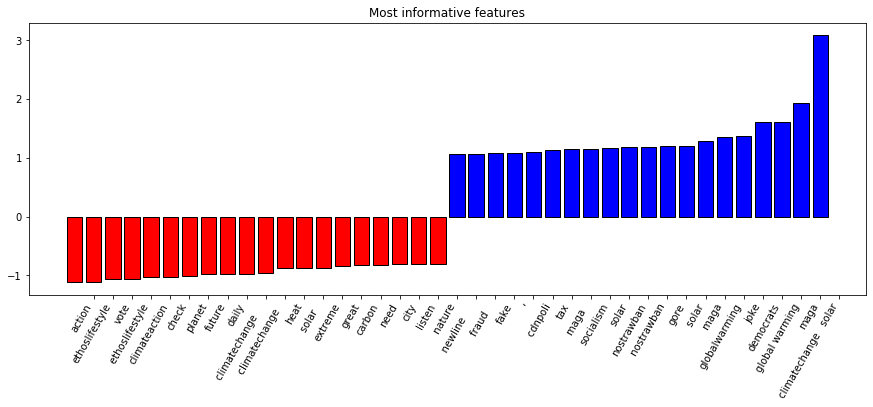

In [19]:
%matplotlib inline

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title("Most informative features")
    plt.show()
    
plot_coefficients(model_final, vectorizer.get_feature_names())

For each location, for each time period, I use the final model to classify tweets and report the number/proportion of believer and denier tweets. 

In [22]:
twitter_username_re = re.compile(r"(^|[^\w@/\!?=&])@(\w{1,15})\b")
url_re = re.compile(r"\bhttps://t.co/\w+")
num_re = re.compile(r"\w*\d\w*")
hashtag_re = re.compile(r"\B(\#[a-zA-Z]+\b)(?!;)")

def is_english(tweet):
    # users, hashtags, numbers, urls mess with the detector, so remove them
    tweet = twitter_username_re.sub("", tweet)
    tweet = url_re.sub("", tweet)
    tweet = hashtag_re.sub(" ", tweet)
    tweet = tweet.replace("#", "").replace("…", "")
    tweet = tweet.replace("&amp;", "").replace("@", "")
    tweet = tweet.replace("<NEWLINE> ", "")
    
    try:
        lang = cld3.get_language(tweet)
        # if we're not sure, just say it's english
        if not lang.is_reliable:
            return True
        return lang.language == 'en'
    
    
    # again, if we're not sure, just say it's english
    except:
        return True

In [23]:
import numpy as np

def classify_tweets(location, before_after):
    # grab tweets from file
    f = open("../data-collection/climate-tweets/" + location.lower() + "-climate-tweets-" + before_after + ".txt", 'r')
    file_content = f.readlines()
    f.close()
    
    # populate test set with tweet text
    X_final_test = []
    for line in file_content:
        # ignore the type of climate change tweet
        reduced_line = '\t'.join(line.split('\t')[:-1])
        # get only the tweet text without emojis
        tweet_text = give_emoji_free_text(reduced_line.split('\t', 2)[2])
        if tweet_text[:2] == "RT" or not is_english(tweet_text):
            continue
        X_final_test.append(tweet_text.replace("<NEWLINE>", ""))
        
    # use model to predict classification of tweets
    X_final_test_cv = vectorizer.transform(X_final_test)
    y_final_predict = model_final.predict_proba(X_final_test_cv)
    
    # classify tweets using predicted probabilities and optimal threshold
    believer_denier_preds = []
    for i in y_final_predict:
        if i[1] < optimal_threshold:
            believer_denier_preds.append(0)
        else:
            believer_denier_preds.append(1)
            
    # report results
    num_believer = len([x for x in believer_denier_preds if x == 0])
    num_denier   = len(X_final_test) - num_believer
    pct_believer = round(num_believer / len(X_final_test), 4) * 100
    pct_denier   = round(num_denier / len(X_final_test), 4) * 100
    
    print(location.upper(), "CLIMATE TWEETS FROM", before_after.upper(), "COVID-19")
    print("---------------------------------------------------")
    print(num_believer, "tweets classified as believer")
    print(num_denier, "tweets classified as denier")
    print(pct_believer, "% believer, ", pct_denier, "% denier\n")
    
    # show examples
    believe_examples = []
    deny_examples = []
    for i in np.arange(len(X_final_test)):
        bd = believer_denier_preds[i]
        if bd == 1 and len(deny_examples) < 3:
            deny_examples += [X_final_test[i]]
        elif bd == 0 and len(believe_examples) < 3:
            believe_examples += [X_final_test[i]]
        
        if len(deny_examples) >= 3 and len(believe_examples) >= 3:
            break
    
    print("EXAMPLES:")
    print("Believer:")
    for x in believe_examples:
        print('-', x)
    print("\nDenier:")
    for x in deny_examples:
        print('-', x)
    print('\n')
    
    return pct_denier

Sydney
SYDNEY CLIMATE TWEETS FROM BEFORE COVID-19
---------------------------------------------------
973 tweets classified as believer
13 tweets classified as denier
98.68 % believer,  1.32 % denier

EXAMPLES:
Believer:
- Good to see Obama shirtfront Abbott on climate change.
- You can act now by not buying palm oil products from country's destroying our environment and endangered species. C… https://t.co/wtpuLJVx7K
- @RoasterMcD @percyvale21 @GuardianAus A policy free zone, on climate and energy

Denier:
- I liked a @YouTube video https://t.co/2nTt4FHNlF Australian agtech company expands its AI tech, helping growers combat climate change
- Reuters: Trump admin telling EPA to pull climate change info https://t.co/qDrjT6peGY via @engadget
- I added a video to a @YouTube playlist https://t.co/A674gnD7hR PTE Academic Speaking Re tell Lecture Practice Set 1


SYDNEY CLIMATE TWEETS FROM AFTER COVID-19
---------------------------------------------------
397 tweets classified as believer
3 t

LA CLIMATE TWEETS FROM AFTER COVID-19
---------------------------------------------------
1339 tweets classified as believer
27 tweets classified as denier
98.02 % believer,  1.9800000000000002 % denier

EXAMPLES:
Believer:
- If our body is all electric and we add more electrical waves &amp; radiation to the environment, you CANT CANT CANT CAN… https://t.co/A5xDhyQXp0
- buffyfan145: Just got to watch “I Still Believe” and loved it!!! :D I’ve been a fan of Jeremy Camp’s for about 18 y… https://t.co/fGGNd3vYqt
- Look like it’s finna be a drought

Denier:
- @_unfeel_ @sue_tex It’s the way that the progressive socialist democrats think. 1 model say we have global warming… https://t.co/hmvy1q8Nm1
- God sent lil @GretaThunberg first. She was so pissed off, she went back and told God, "Fuck em, do the plague thin… https://t.co/qQZGYOevun
- @niev0000 @JimSnyd44747739 @RashidaTlaib What's more stupid than that? Exploiting an autistic kid to champion bogus climate change "science"




Text(0.5, 1.0, "Percent of climate tweets classified as 'denier'")

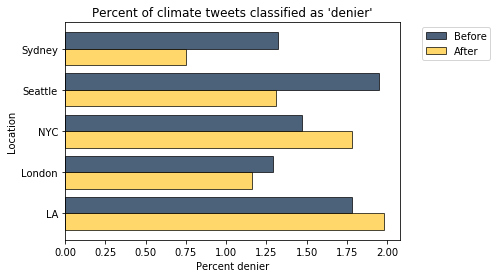

In [24]:
loc_list = ["Sydney", "Seattle", "NYC", "London", "LA"]
before = []
after = []

for loc in loc_list:
    print(loc)
    before.append(classify_tweets(loc, "before"))
    after.append(classify_tweets(loc, "after"))
    
table = Table().with_columns("Location", loc_list,
                             "Before", before,
                             "After", after)

table.barh("Location")
plt.xlabel("Percent denier")
plt.title("Percent of climate tweets classified as 'denier'")

In [25]:
table.show()

In [26]:
def classify_all_tweets(ba):
    # grab tweets from file
    f = open("../data-collection/climate-tweets/" + ba + "-covid-climate-tweets-all.txt", 'r')
    file_content = f.readlines()
    f.close()
    
    # populate test set with tweet text
    X_final_test = []
    for line in file_content:
        # ignore the type of climate change tweet
        reduced_line = '\t'.join(line.split('\t')[:-1])
        # get only the tweet text without emojis
        tweet_text = give_emoji_free_text(reduced_line.split('\t', 2)[2])
        # check that tweet isn't a retweet and is in english
        if tweet_text[:2] == "RT" or not is_english(tweet_text):
            continue
        X_final_test.append(tweet_text.replace("<NEWLINE>", ""))
        
    # use model to predict classification of tweets
    X_final_test_cv = vectorizer.transform(X_final_test)
    y_final_predict = model_final.predict_proba(X_final_test_cv)
    
    # classify tweets using predicted probabilities and optimal threshold
    believer_denier_preds = []
    for i in y_final_predict:
        if i[1] < optimal_threshold:
            believer_denier_preds.append(0)
        else:
            believer_denier_preds.append(1)
            
    # report results
    num_believer = len([x for x in believer_denier_preds if x == 0])
    num_denier   = len(X_final_test) - num_believer
    pct_believer = round(num_believer / len(X_final_test), 4) * 100
    pct_denier   = round(num_denier / len(X_final_test), 4) * 100
    
    print("ALL CLIMATE TWEETS FROM", ba.upper(), "COVID-19")
    print("---------------------------------------------------")
    print(num_believer, "tweets classified as believer")
    print(num_denier, "tweets classified as denier")
    print(pct_believer, "% believer, ", pct_denier, "% denier\n")
    
    # show examples
    believe_examples = []
    deny_examples = []
    for i in np.arange(len(X_final_test)):
        bd = believer_denier_preds[i]
        if bd == 1 and len(deny_examples) < 3:
            deny_examples += [X_final_test[i]]
        elif bd == 0 and len(believe_examples) < 3:
            believe_examples += [X_final_test[i]]
        
        if len(deny_examples) >= 3 and len(believe_examples) >= 3:
            break
    
    print("EXAMPLES:")
    print("Believer:")
    for x in believe_examples:
        print('-', x)
    print("\nDenier:")
    for x in deny_examples:
        print('-', x)
    print('\n')

In [27]:
classify_all_tweets("before")
classify_all_tweets("after")

ALL CLIMATE TWEETS FROM BEFORE COVID-19
---------------------------------------------------
8049 tweets classified as believer
121 tweets classified as denier
98.52 % believer,  1.48 % denier

EXAMPLES:
Believer:
- Good to see Obama shirtfront Abbott on climate change.
- You can act now by not buying palm oil products from country's destroying our environment and endangered species. C… https://t.co/wtpuLJVx7K
- @RoasterMcD @percyvale21 @GuardianAus A policy free zone, on climate and energy

Denier:
- I liked a @YouTube video https://t.co/2nTt4FHNlF Australian agtech company expands its AI tech, helping growers combat climate change
- Reuters: Trump admin telling EPA to pull climate change info https://t.co/qDrjT6peGY via @engadget
- I added a video to a @YouTube playlist https://t.co/A674gnD7hR PTE Academic Speaking Re tell Lecture Practice Set 1


ALL CLIMATE TWEETS FROM AFTER COVID-19
---------------------------------------------------
4717 tweets classified as believer
73 tweets cla